In [1]:
import pandas as pd
import mysql.connector
import torch
import torch.nn as nn
from numpy.ma.core import count
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
df_acad = pd.read_excel( "../tabelas_alteradas/indicadores_trajetoria_educacao_superior.xlsx")
df_renda = pd.read_excel( "../tabelas_alteradas/rendimento_domiciliar_per_capita.xlsx")

In [3]:
print(df_acad)

        Código da Instituição  \
0                           1   
1                           1   
2                           1   
3                           1   
4                           1   
...                       ...   
173365                  29929   
173366                  29929   
173367                  29929   
173368                  29929   
173369                  29929   

                                      Nome da Instituição  \
0                     UNIVERSIDADE FEDERAL DE MATO GROSSO   
1                     UNIVERSIDADE FEDERAL DE MATO GROSSO   
2                     UNIVERSIDADE FEDERAL DE MATO GROSSO   
3                     UNIVERSIDADE FEDERAL DE MATO GROSSO   
4                     UNIVERSIDADE FEDERAL DE MATO GROSSO   
...                                                   ...   
173365  COLÉGIO TECNOLÓGICO DO ESTADO DE GOIÁS GOVERNA...   
173366  COLÉGIO TECNOLÓGICO DO ESTADO DE GOIÁS GOVERNA...   
173367  COLÉGIO TECNOLÓGICO DO ESTADO DE GOIÁS GOVERNA

In [4]:
print(df_renda)

    regioes  media_com_beneficios_2023  media_cv_com_beneficios_2023  \
0        11                1523.396675                      3.600024   
1        12                1074.354951                      4.174085   
2        13                1165.820253                      5.038382   
3        14                1428.220491                      7.613953   
4        15                1273.037987                      3.593628   
5        16                1491.759183                      5.520468   
6        17                1544.286351                      4.078528   
7        21                 968.525644                      3.373580   
8        22                1326.545758                     12.296357   
9        23                1140.190987                      4.533213   
10       24                1349.867252                      5.709592   
11       25                1322.739642                      8.324182   
12       26                1099.219181                      3.56

In [5]:
import mysql.connector

conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="0000"
)
print("Conectado com sucesso!")


Conectado com sucesso!


In [6]:
# Conectando com o mysql
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="0000",
)
cursor = conn.cursor()

cursor.execute("CREATE DATABASE IF NOT EXISTS datawarehouse") # Criando Banco
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="0000",
    database="datawarehouse"
)
cursor = conn.cursor()

In [7]:
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="0000",
    database="datawarehouse"
)
cursor = conn.cursor()
# Criando tabelas caso não exista no banco
tabelas_sql = [
    """
    CREATE TABLE IF NOT EXISTS `cursos` (
        `cur_id` int NOT NULL,
        `cur_cod` int DEFAULT NULL,
        `cur_nome` varchar(255) DEFAULT NULL,
        `cur_cod_area` varchar(20) DEFAULT NULL,
        `cur_nome_area` varchar(255) DEFAULT NULL,
        `cur_modalidade_ensino` varchar(100) DEFAULT NULL,
        PRIMARY KEY (`cur_id`)
    )
    """,
    """
    CREATE TABLE IF NOT EXISTS `tempo` (
        `tem_id` int unsigned NOT NULL AUTO_INCREMENT,
        `tem_ano` int NOT NULL,
        PRIMARY KEY (`tem_id`)
    )
    """,
    """
    CREATE TABLE IF NOT EXISTS `uf` (
        `uf_id` int unsigned NOT NULL,
        `uf_nome` varchar(255) NOT NULL DEFAULT '',
        `uf_sigla` char(2) NOT NULL DEFAULT '',
        PRIMARY KEY (`uf_id`)
    )
    """,
    """
    CREATE TABLE IF NOT EXISTS `universidades` (
        `uni_id` int NOT NULL,
        `uni_nome` varchar(255) DEFAULT NULL,
        PRIMARY KEY (`uni_id`)
    )
    """,
    """
    CREATE TABLE IF NOT EXISTS `indicadores_academicos` (
        `uni_id` int NOT NULL,
        `cur_id` int NOT NULL,
        `uf_id` int unsigned NOT NULL,
        `tem_id` int unsigned NOT NULL,
        `ano_ingresso` int NOT NULL,
        `prazo_integracao_anos` int NOT NULL,
        `ano_integracao_curso` int NOT NULL,
        `prazo_acompanhamento_anos` int NOT NULL,
        `ano_maximo_acompanhamento` int NOT NULL,
        `qt_ingressantes` int DEFAULT '0',
        `qt_permanencia` int DEFAULT '0',
        `qt_concluintes` int DEFAULT '0',
        `qt_desistencia` int DEFAULT '0',
        `qt_falecidos` int DEFAULT '0',
        `taxa_permanencia` float DEFAULT '0',
        `taxa_conclusao_acumulada` float DEFAULT '0',
        `taxa_desistencia_acumulada` float DEFAULT '0',
        `taxa_conclusao_anual` float DEFAULT '0',
        `taxa_desistencia_anual` float DEFAULT '0',
        PRIMARY KEY (`uni_id`,`cur_id`,`uf_id`,`tem_id`),
        KEY `idicadores_academicos_fk_3` (`uf_id`),
        KEY `indicadores_academicos_fk_2` (`cur_id`),
        KEY `indicadores_academicos_fk_3` (`tem_id`),
        CONSTRAINT `idicadores_academicos_fk_3` FOREIGN KEY (`uf_id`) REFERENCES `uf` (`uf_id`),
        CONSTRAINT `indicadores_academicos_fk_1` FOREIGN KEY (`uni_id`) REFERENCES `universidades` (`uni_id`),
        CONSTRAINT `indicadores_academicos_fk_2` FOREIGN KEY (`cur_id`) REFERENCES `cursos` (`cur_id`),
          CONSTRAINT `indicadores_academicos_fk_3` FOREIGN KEY (`tem_id`) REFERENCES `tempo` (`tem_id`)
    )
    """,
    """
    CREATE TABLE IF NOT EXISTS `indicadores_economicos` (
        `uf_id` int unsigned NOT NULL,
        `tem_id` int unsigned NOT NULL,
        `inec_rendimento_medio_percapita_sem_beneficio` float DEFAULT '0',
        `inec_rendimento_medio_percapita_com_beneficio` float DEFAULT '0',
        `inec_coeficiente_variacao_rendimento_com_beneficio` float DEFAULT '0',
        `inec_coeficiente_variacao_rendimento_sem_beneficio` float DEFAULT '0',
        KEY `indicadoreseconomicos_fk_1` (`uf_id`),
        KEY `indicadores_economicos_fk_2` (`tem_id`),
        CONSTRAINT `indicadores_economicos_fk_2` FOREIGN KEY (`tem_id`) REFERENCES `tempo` (`tem_id`),
        CONSTRAINT `indicadoreseconomicos_fk_1` FOREIGN KEY (`uf_id`) REFERENCES `uf` (`uf_id`)
    )
    """,
]

for sql in tabelas_sql:
    cursor.execute(sql)

In [8]:
# Inserir dados no banco
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="0000",
    database="datawarehouse"
)
cursor = conn.cursor()
# Setando dados dos estados

cursor.execute("""
    INSERT IGNORE INTO uf (uf_id, uf_nome, uf_sigla) VALUES
    (11, 'Rondônia', 'RO'),
    (12, 'Acre', 'AC'),
    (13, 'Amazonas', 'AM'),
    (14, 'Roraima', 'RR'),
    (15, 'Pará', 'PA'),
    (16, 'Amapá', 'AP'),
    (17, 'Tocantins', 'TO'),
    (21, 'Maranhão', 'MA'),
    (22, 'Piauí', 'PI'),
    (23, 'Ceará', 'CE'),
    (24, 'Rio Grande do Norte', 'RN'),
    (25, 'Paraíba', 'PB'),
    (26, 'Pernambuco', 'PE'),
    (27, 'Alagoas', 'AL'),
    (28, 'Sergipe', 'SE'),
    (29, 'Bahia', 'BA'),
    (31, 'Minas Gerais', 'MG'),
    (32, 'Espírito Santo', 'ES'),
    (33, 'Rio de Janeiro', 'RJ'),
    (35, 'São Paulo', 'SP'),
    (41, 'Paraná', 'PR'),
    (42, 'Santa Catarina', 'SC'),
    (43, 'Rio Grande do Sul', 'RS'),
    (50, 'Mato Grosso do Sul', 'MS'),
    (51, 'Mato Grosso', 'MT'),
    (52, 'Goiás', 'GO'),
    (53, 'Distrito Federal', 'DF');
""")

# Setando dados do tempo

cursor.execute("""
    INSERT IGNORE INTO tempo (tem_id, tem_ano) VALUES
    (1, 2020),
    (2, 2021),
    (3, 2022),
    (4, 2023),
    (5, 2024),
    (6, 2025);
""")

# Formatando dados para inserir na tabela indicadores economicos
dados = []
cursor.execute("SELECT tem_id, tem_ano FROM tempo;")
mapa_tempo = {ano: tem_id for tem_id, ano in cursor.fetchall()}


for i, row in df_renda.iterrows():
    uf_id = row["regioes"]

    for ano in [2020, 2021, 2022, 2023]:
        dados.append({
            "uf_id": uf_id,
            "ano": ano,
            "media_com_beneficios": row[f"media_com_beneficios_{ano}"],
            "media_sem_beneficios": row[f"media_sem_beneficios_{ano}"],
            "coeficiente_variacao_com_beneficios": row[f"media_cv_com_beneficios_{ano}"],
            "coeficiente_variacao_sem_beneficios": row[f"media_cv_sem_beneficios_{ano}"]
        })


df_preparado = pd.DataFrame(dados)

valores = []

for i, row in df_preparado.iterrows():
    tem_id = mapa_tempo[row["ano"]]
    valores.append((
        int(row["uf_id"]),
        int(tem_id),
        row["media_com_beneficios"],
        row["media_sem_beneficios"],
        row["coeficiente_variacao_com_beneficios"],
        row["coeficiente_variacao_sem_beneficios"]
    ))

sql = """
    INSERT IGNORE INTO indicadores_economicos (
        uf_id, tem_id,
        inec_rendimento_medio_percapita_com_beneficio,
        inec_rendimento_medio_percapita_sem_beneficio,
        inec_coeficiente_variacao_rendimento_com_beneficio,
        inec_coeficiente_variacao_rendimento_sem_beneficio
    )
    VALUES (%s, %s, %s, %s, %s, %s)
"""

cursor.executemany(sql, valores)

# Tratando dados academicos

universidades = []
# Usando um set para evitar duplicatas
seen_unis = set()

for i, row in df_acad.iterrows():
    uni_id = int(row["Código da Instituição"])
    uni_nome = row["Nome da Instituição"]
    if uni_id not in seen_unis:
        universidades.append((uni_id, uni_nome))
        seen_unis.add(uni_id)

sql_uni = """
INSERT IGNORE INTO universidades (uni_id, uni_nome) VALUES (%s, %s)
"""
cursor.executemany(sql_uni, universidades)

cursos = []
seen_cursos = set()

for i, row in df_acad.iterrows():
    cur_id = int(row["Código do Curso de Graduação"])
    cur_nome = row["Nome do Curso de Graduação"]
    cur_cod_area  = row.get("Código da área do Curso segundo a classificação CINE BRASIL", "")
    cur_nome_area = row.get("Nome da área do Curso segundo a classificação CINE BRASIL", "")
    cur_modalidade_ensino = row.get("Modalidade de Ensino", "")

    if cur_id not in seen_cursos:
        cursos.append((cur_id, None, cur_nome, cur_cod_area, cur_nome_area, cur_modalidade_ensino))
        seen_cursos.add(cur_id)

sql_cursos = """
INSERT IGNORE INTO cursos (cur_id, cur_cod, cur_nome, cur_cod_area, cur_nome_area, cur_modalidade_ensino)
VALUES (%s, %s, %s, %s, %s, %s)
"""
cursor.executemany(sql_cursos, cursos)

# === 4. Inserir fatos acadêmicos ===
valores = []

for i, row in df_acad.iterrows():
    try:
        tem_id = mapa_tempo[int(row["Ano de Referência"])]
    except KeyError:
        continue

    if pd.isna(row["Código da Unidade Federativa do Curso"]): # Universidades EAD, não servirá para nossos testes.
        continue

    valores.append((
        int(row["Código da Instituição"]),
        int(row["Código do Curso de Graduação"]),
        int(row["Código da Unidade Federativa do Curso"]),
        tem_id,
        int(row["Ano de Ingresso"]),
        int(row["Prazo de Integralização em Anos"]),
        int(row["Ano de Integralização do Curso"]),
        int(row["Prazo de Acompanhamento do Curso em anos"]),
        int(row["Ano Máximo de Acompanhamento do Curso"]),
        int(row.get("Quantidade de Ingressantes no Curso", 0)),
        int(row.get("Quantidade de Permanência no Curso no ano de referência", 0)),
        int(row.get("Quantidade de Concluintes no Curso no ano de referência", 0)),
        int(row.get("Quantidade de Desistência no Curso no ano de referência", 0)),
        int(row.get("Quantidade de Falecimentos no Curso no ano de referência", 0)),
        float(row.get("Taxa de Permanência - TAP", 0)),
        float(row.get("Taxa de Conclusão Acumulada - TCA", 0)),
        float(row.get("Taxa de Desistência Acumulada - TDA", 0)),
        float(row.get("Taxa de Conclusão Anual – TCAN", 0)),
        float(row.get("Taxa de Desistência Anual – TADA", 0))
    ))

sql_acad = """
INSERT IGNORE INTO indicadores_academicos (
    uni_id, cur_id, uf_id, tem_id,
    ano_ingresso, prazo_integracao_anos, ano_integracao_curso,
    prazo_acompanhamento_anos, ano_maximo_acompanhamento,
    qt_ingressantes, qt_permanencia, qt_concluintes,
    qt_desistencia, qt_falecidos,
    taxa_permanencia, taxa_conclusao_acumulada, taxa_desistencia_acumulada,
    taxa_conclusao_anual, taxa_desistencia_anual
) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
"""

cursor.executemany(sql_acad, valores)
conn.commit()
cursor.close()
conn.close()

Análise Descritiva do Panorama Educacional e Econômico por Estado e Ano



In [9]:
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="0000",
    database="datawarehouse"
)

query = """
SELECT
    uf.uf_sigla AS estado,
    t.tem_ano AS ano,
    u.uni_nome AS universidade,
    c.cur_nome AS curso,
    COALESCE(ia.taxa_permanencia, 0) AS taxa_permanencia,
    COALESCE(ia.taxa_conclusao_acumulada, 0) AS taxa_conclusao_acumulada,
    COALESCE(ia.taxa_desistencia_acumulada, 0) AS taxa_desistencia_acumulada,
    COALESCE(ia.taxa_conclusao_anual, 0) AS taxa_conclusao_anual,
    COALESCE(ia.taxa_desistencia_anual, 0) AS taxa_desistencia_anual,
    COALESCE(ie.inec_rendimento_medio_percapita_com_beneficio, 0) AS rendimento_medio,
    COALESCE(ie.inec_rendimento_medio_percapita_sem_beneficio, 0) AS rendimento_medio_sem_auxilio,
    COALESCE(ie.inec_coeficiente_variacao_rendimento_com_beneficio, 0) AS coeficiente_variacao
FROM uf
CROSS JOIN tempo t
LEFT JOIN indicadores_academicos ia
    ON ia.uf_id = uf.uf_id AND ia.tem_id = t.tem_id
LEFT JOIN universidades u ON ia.uni_id = u.uni_id
LEFT JOIN cursos c ON ia.cur_id = c.cur_id
LEFT JOIN indicadores_economicos ie
    ON ie.uf_id = uf.uf_id AND ie.tem_id = t.tem_id
ORDER BY uf.uf_sigla, t.tem_ano, universidade, curso;
"""

df = pd.read_sql(query, conn)
df['estado'].value_counts()

df.head(5000)

C:\Users\IgorA\AppData\Local\Temp\ipykernel_18548\2783040611.py:33: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,estado,ano,universidade,curso,taxa_permanencia,taxa_conclusao_acumulada,taxa_desistencia_acumulada,taxa_conclusao_anual,taxa_desistencia_anual,rendimento_medio,rendimento_medio_sem_auxilio,coeficiente_variacao
0,AC,2020,Centro Univeritário UniVOLTAIRE,ADMINISTRAÇÃO,77.7778,5.55556,16.6667,5.55556,16.6667,1122.500,980.321,4.58988
1,AC,2020,Centro Univeritário UniVOLTAIRE,ADMINISTRAÇÃO,77.7778,5.55556,16.6667,5.55556,16.6667,1122.500,980.321,4.58988
2,AC,2020,Centro Univeritário UniVOLTAIRE,ADMINISTRAÇÃO,77.7778,5.55556,16.6667,5.55556,16.6667,1122.500,980.321,4.58988
3,AC,2020,Centro Univeritário UniVOLTAIRE,ADMINISTRAÇÃO,77.7778,5.55556,16.6667,5.55556,16.6667,1122.500,980.321,4.58988
4,AC,2020,Centro Univeritário UniVOLTAIRE,ADMINISTRAÇÃO,77.7778,5.55556,16.6667,5.55556,16.6667,1122.500,980.321,4.58988
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,AL,2020,Faculdade UNIRB - ARAPIRACA,ENFERMAGEM,100.0000,0.00000,0.0000,0.00000,0.0000,955.444,806.320,5.35575
4996,AL,2020,Faculdade UNIRB - ARAPIRACA,ENFERMAGEM,100.0000,0.00000,0.0000,0.00000,0.0000,955.444,806.320,5.35575
4997,AL,2020,Faculdade UNIRB - ARAPIRACA,ENFERMAGEM,100.0000,0.00000,0.0000,0.00000,0.0000,955.444,806.320,5.35575
4998,AL,2020,Faculdade UNIRB - ARAPIRACA,ENFERMAGEM,100.0000,0.00000,0.0000,0.00000,0.0000,955.444,806.320,5.35575


Análise Descritiva do Panorama Educacional e Econômico por Estado, Ano e Estudantes que recebem auxilio

In [10]:
import pandas as pd
import mysql.connector

# Conectar ao banco
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="0000",
    database="datawarehouse"
)

query = """
SELECT
    uf.uf_sigla AS estado,
    t.tem_ano AS ano,
    u.uni_nome AS universidade,
    c.cur_nome AS curso,
    COALESCE(ia.taxa_permanencia, 0) AS taxa_permanencia,
    COALESCE(ia.taxa_conclusao_acumulada, 0) AS taxa_conclusao_acumulada,
    COALESCE(ia.taxa_desistencia_acumulada, 0) AS taxa_desistencia_acumulada,
    COALESCE(ia.taxa_conclusao_anual, 0) AS taxa_conclusao_anual,
    COALESCE(ia.taxa_desistencia_anual, 0) AS taxa_desistencia_anual,
    ie.inec_rendimento_medio_percapita_com_beneficio AS rendimento_com_auxilio,
    ie.inec_rendimento_medio_percapita_sem_beneficio AS rendimento_sem_auxilio
FROM uf
CROSS JOIN tempo t
LEFT JOIN indicadores_academicos ia
    ON ia.uf_id = uf.uf_id AND ia.tem_id = t.tem_id
LEFT JOIN universidades u ON ia.uni_id = u.uni_id
LEFT JOIN cursos c ON ia.cur_id = c.cur_id
LEFT JOIN indicadores_economicos ie
    ON ie.uf_id = uf.uf_id AND ie.tem_id = t.tem_id
ORDER BY uf.uf_sigla, t.tem_ano, universidade, curso;
"""

df = pd.read_sql(query, conn)

# Criar colunas indicando permanência média ajustada por auxílio
# Aqui usamos como proxy o rendimento médio: se maior que zero, considera auxílio
df['permanencia_com_auxilio'] = df['taxa_permanencia'] * (df['rendimento_com_auxilio'] > 0)
df['permanencia_sem_auxilio'] = df['taxa_permanencia'] * (df['rendimento_sem_auxilio'] > 0)

df.head(5000)

C:\Users\IgorA\AppData\Local\Temp\ipykernel_18548\2486088287.py:36: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,estado,ano,universidade,curso,taxa_permanencia,taxa_conclusao_acumulada,taxa_desistencia_acumulada,taxa_conclusao_anual,taxa_desistencia_anual,rendimento_com_auxilio,rendimento_sem_auxilio,permanencia_com_auxilio,permanencia_sem_auxilio
0,AC,2020,Centro Univeritário UniVOLTAIRE,ADMINISTRAÇÃO,77.7778,5.55556,16.6667,5.55556,16.6667,1122.500,980.321,77.7778,77.7778
1,AC,2020,Centro Univeritário UniVOLTAIRE,ADMINISTRAÇÃO,77.7778,5.55556,16.6667,5.55556,16.6667,1122.500,980.321,77.7778,77.7778
2,AC,2020,Centro Univeritário UniVOLTAIRE,ADMINISTRAÇÃO,77.7778,5.55556,16.6667,5.55556,16.6667,1122.500,980.321,77.7778,77.7778
3,AC,2020,Centro Univeritário UniVOLTAIRE,ADMINISTRAÇÃO,77.7778,5.55556,16.6667,5.55556,16.6667,1122.500,980.321,77.7778,77.7778
4,AC,2020,Centro Univeritário UniVOLTAIRE,ADMINISTRAÇÃO,77.7778,5.55556,16.6667,5.55556,16.6667,1122.500,980.321,77.7778,77.7778
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,AL,2020,Faculdade UNIRB - ARAPIRACA,ENFERMAGEM,100.0000,0.00000,0.0000,0.00000,0.0000,955.444,806.320,100.0000,100.0000
4996,AL,2020,Faculdade UNIRB - ARAPIRACA,ENFERMAGEM,100.0000,0.00000,0.0000,0.00000,0.0000,955.444,806.320,100.0000,100.0000
4997,AL,2020,Faculdade UNIRB - ARAPIRACA,ENFERMAGEM,100.0000,0.00000,0.0000,0.00000,0.0000,955.444,806.320,100.0000,100.0000
4998,AL,2020,Faculdade UNIRB - ARAPIRACA,ENFERMAGEM,100.0000,0.00000,0.0000,0.00000,0.0000,955.444,806.320,100.0000,100.0000


Agrupamento KMeans

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt


# Ordena os dados por estado e ano
df = df.sort_values(['estado', 'ano'])

# Cria uma série temporal para cada estado (exemplo: taxa de permanência)
pivot = df.pivot_table(values='taxa_permanencia', index='estado', columns='ano', fill_value=0)

X_ts = pivot.values  # cada linha = um estado, cada coluna = um ano
estados = pivot.index.to_list()

print("Formato da matriz de séries:", X_ts.shape)


Formato da matriz de séries: (27, 6)


Extraindo features das séries temporais


Padronizando e aplicando KMeans

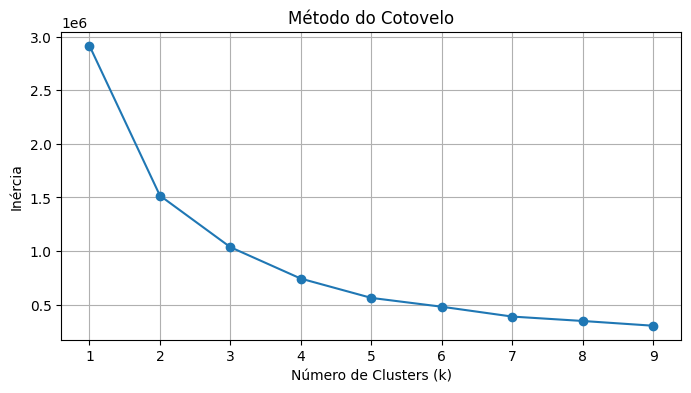

         taxa_permanencia  rendimento_com_auxilio  rendimento_sem_auxilio
cluster                                                                  
0               57.408262             1115.449747             1022.214900
1               79.550830             1949.848813             1899.791760
2               23.475819             2144.448976             2105.717671


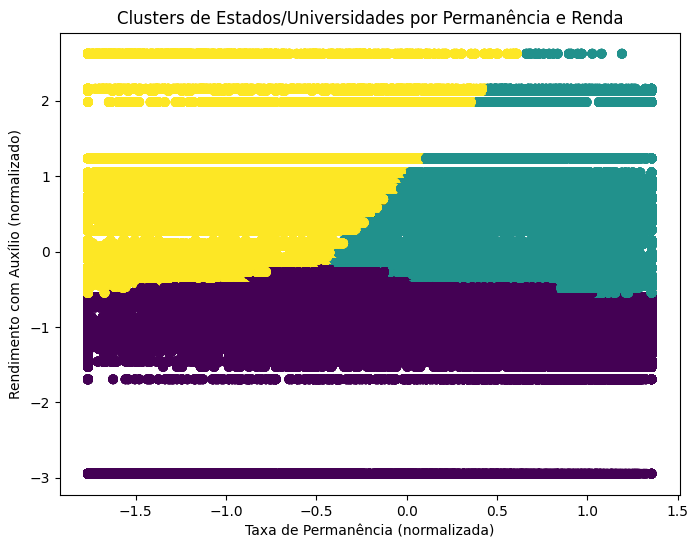

In [12]:
#Importando bibliotecas
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

#Selecionando as variáveis relevantes
variaveis = ['taxa_permanencia', 'rendimento_com_auxilio', 'rendimento_sem_auxilio']
X = df[variaveis].fillna(0)

#Padronizando os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Cotovelo
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,4))
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Método do Cotovelo')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.grid(True)
plt.show()

#Aplicando o K-Means
k_optimo = 3  # ajuste conforme o gráfico
kmeans = KMeans(n_clusters=k_optimo, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

#Analisando os resultados
print(df.groupby('cluster')[variaveis].mean())

# Visualizando
plt.figure(figsize=(8,6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=df['cluster'], cmap='viridis')
plt.title('Clusters de Estados/Universidades por Permanência e Renda')
plt.xlabel('Taxa de Permanência (normalizada)')
plt.ylabel('Rendimento com Auxílio (normalizado)')
plt.show()


FEAUTURES E CLUSTER


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.signal import periodogram

def slope_via_linreg(y):
    x = np.arange(len(y))
    x_mean, y_mean = x.mean(), y.mean()
    num = np.sum((x - x_mean) * (y - y_mean))
    den = np.sum((x - x_mean) ** 2) + 1e-12
    return num / den

def autocorr_lag1(y):
    y = y - y.mean()
    num = np.sum(y[1:] * y[:-1])
    den = np.sum(y[:-1] ** 2) + 1e-12
    return num / den

def dominant_freq(y, fs=1.0):
    f, Pxx = periodogram(y, fs=fs)
    if len(Pxx) > 1:
        idx = np.argmax(Pxx[1:]) + 1
        return f[idx]
    return 0.0

def extract_features_matrix(X):
    feats = []
    for y in X:
        mean = np.mean(y)
        std = np.std(y)
        slp = slope_via_linreg(y)
        ac1 = autocorr_lag1(y)
        y_norm = (y - mean) / (std + 1e-12)
        domf = dominant_freq(y_norm, fs=1.0)
        feats.append([mean, std, slp, ac1, domf])
    return np.array(feats)

def plot_cluster_averages(X, labels, k, title="Médias por cluster"):
    plt.figure(figsize=(12, 6))
    for c in range(k):
        avg = X[labels == c].mean(axis=0)
        plt.plot(avg, linewidth=2, label=f"Cluster {c} (n={np.sum(labels==c)})")
    plt.title(title)
    plt.xlabel("Tempo")
    plt.ylabel("Valor médio")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_examples_by_cluster(X, labels, k, n_show=5):
    for c in range(k):
        idx = np.where(labels == c)[0]
        plt.figure(figsize=(10, 4))
        for i in np.random.choice(idx, size=min(n_show, len(idx)), replace=False):
            plt.plot(X[i], alpha=0.8)
        plt.title(f"Exemplos do Cluster {c} (n={len(idx)})")
        plt.xlabel("Tempo")
        plt.ylabel("Valor")
        plt.grid(True, alpha=0.3)
        plt.show()

In [14]:
def run_kmeans(X_ts, entity_names, title_prefix="Cluster"):
    # Extrai features
    X_feat = extract_features_matrix(X_ts)
    Xz = StandardScaler().fit_transform(X_feat)

    # Testa k de 2 a 8
    k_range = range(2, 9)
    sil_vals, ch_vals = [], []
    for k in k_range:
        km = KMeans(n_clusters=k, n_init="auto", random_state=42)
        labels = km.fit_predict(Xz)
        sil_vals.append(silhouette_score(Xz, labels))
        ch_vals.append(calinski_harabasz_score(Xz, labels))

    # Melhor k via silhouette
    best_k = k_range[np.argmax(sil_vals)]
    print(f"Melhor k (Silhouette) para {title_prefix}: {best_k}")

    # K-Means final
    km = KMeans(n_clusters=best_k, n_init="auto", random_state=42)
    labels = km.fit_predict(Xz)

    # PCA para visualização
    pca = PCA(n_components=2, random_state=42)
    XZ2 = pca.fit_transform(Xz)

    plt.figure(figsize=(6,5))
    for c in range(best_k):
        plt.scatter(XZ2[labels==c,0], XZ2[labels==c,1], label=f"Cluster {c}")
    plt.title(f"{title_prefix} - PCA")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Média por cluster e exemplos
    plot_cluster_averages(X_ts, labels, best_k, title=f"{title_prefix} - Médias por cluster")
    plot_examples_by_cluster(X_ts, labels, best_k, n_show=5)

    # Retorna DataFrame com cluster por entidade
    df_result = pd.DataFrame({"entidade": entity_names, "cluster": labels})
    return df_result


# Tipo de Instituição
Usando Kmeans e Cluster


Melhor k (Silhouette) para Tipo Instituição: 6


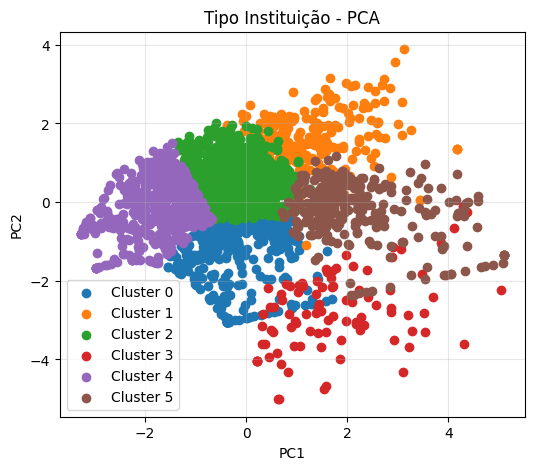

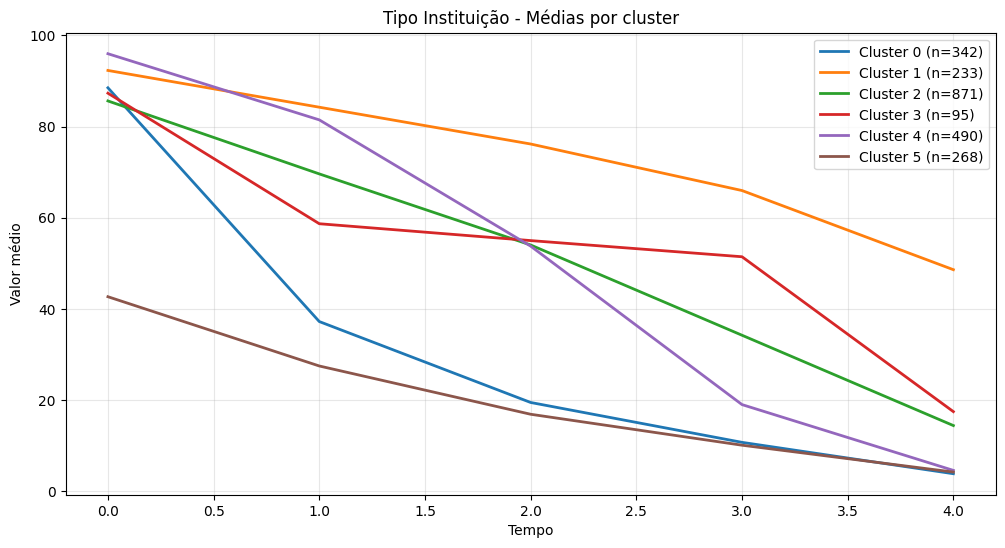

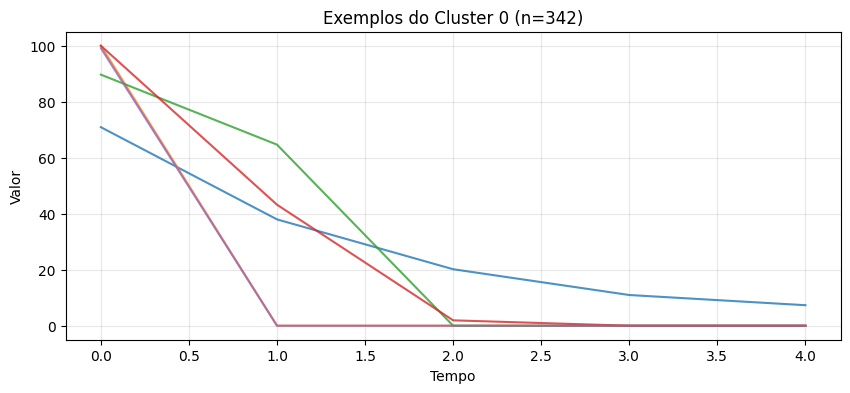

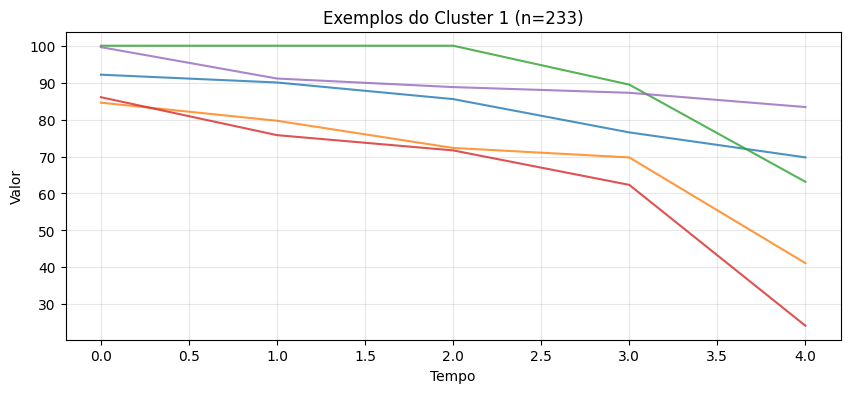

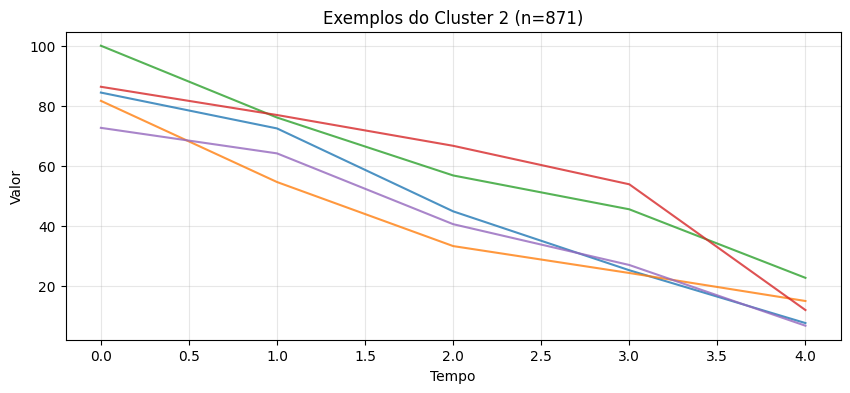

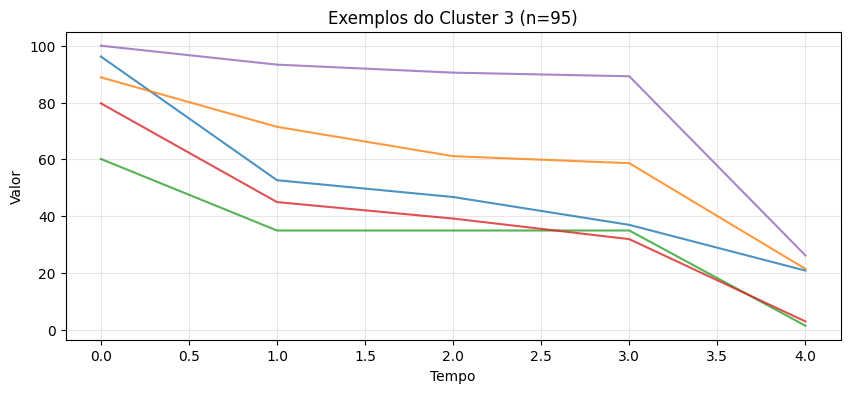

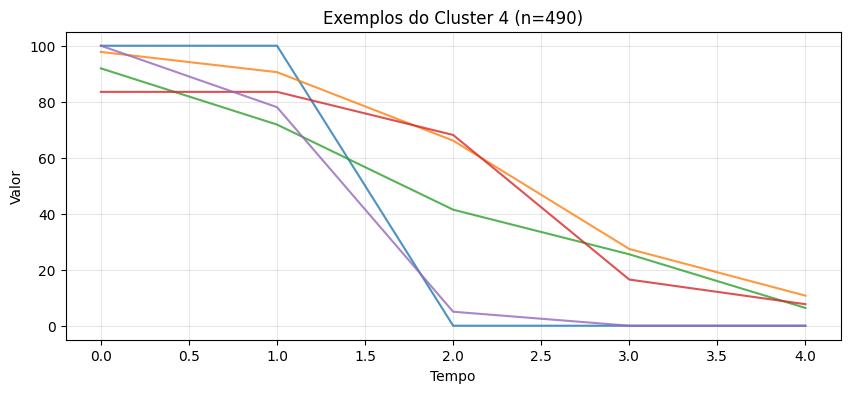

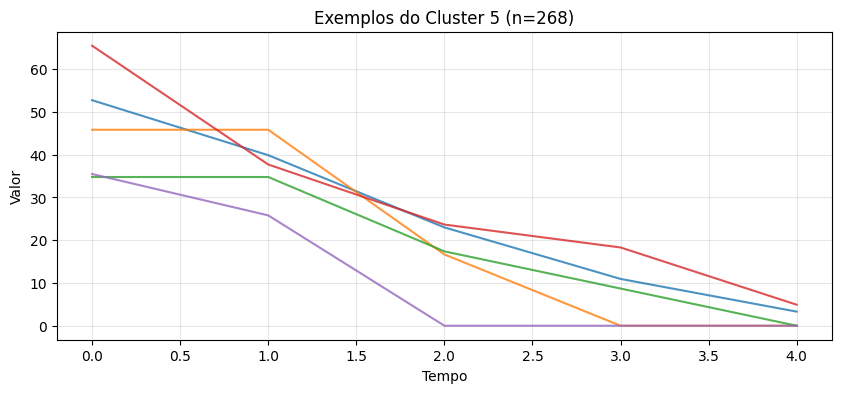

                                               entidade  cluster
0                           ABEU - CENTRO UNIVERSITÁRIO        0
1      AFYA FACULDADE DE CIÊNCIAS MÉDICAS DE SANTA INÊS        1
2          AFYA Faculdade de Ciências Médicas de Palmas        1
3                   AJES - FACULDADE DO VALE DO JURUENA        3
4                   Academia Militar das Agulhas Negras        4
...                                                 ...      ...
2294         Universidade Federal do Norte do Tocantins        2
2295           Universidade Pitágoras Unopar Anhanguera        5
2296           Universidade Universus Veritas Guarulhos        0
2297  Universidade do Estado de Mato Grosso Carlos A...        2
2298                iCEV - Instituto de Ensino Superior        2

[2299 rows x 2 columns]


In [15]:
pivot_inst = df.pivot_table(values='taxa_permanencia', index='universidade', columns='ano', fill_value=0)
result3 = run_kmeans(pivot_inst.values, pivot_inst.index.to_list(), title_prefix="Tipo Instituição")
print(result3)


Cluster 0: Universidades com permanência relativamente estável ou média.

Cluster 1: Universidades com taxas mais altas ou tendência crescente.

Clusters 2 a 5: padrões variados, podendo indicar universidades públicas ou privadas com altos/baixos índices de evasão.

# Impacto de programas sociais / políticas públicas

FAZER COMPARAÇÃO ENTRE RENDIMENTO COM AUX E RENDIMENTO SEM AUX NAO É P USAR CLUSTER


Impacto médio do auxílio no rendimento por estado:
estado
PI    109.14450
AL    108.13850
PB    108.01350
BA    107.14050
CE     99.36800
SE     98.34850
MA     95.74075
PA     95.44025
AC     91.98375
PE     91.23475
RN     88.44750
AM     86.71425
AP     84.47975
TO     73.63000
RO     61.81250
MS     61.64750
RR     61.38250
GO     57.51500
MG     57.28500
ES     56.55500
MT     51.38250
RJ     48.66250
SP     41.30750
DF     41.05250
RS     40.15750
PR     40.13750
SC     23.98500
dtype: float64


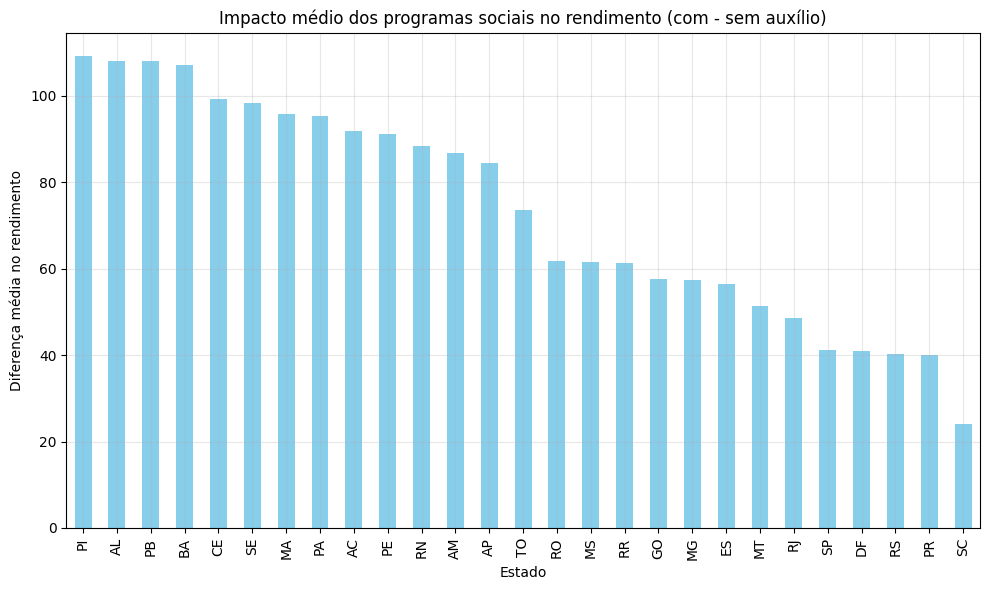

In [16]:
#pivot_aux = df.pivot_table(values='rendimento_com_auxilio', index='estado', columns='ano', fill_value=0)
#pivot_sem = df.pivot_table(values='rendimento_sem_auxilio', index='estado', columns='ano', fill_value=0)
#impacto = pivot_aux - pivot_sem
#result2 = run_kmeans(impacto.values, pivot_aux.index.to_list(), title_prefix="Impacto Programas Sociais e Políticas Públicas")
#print(result2)



import matplotlib.pyplot as plt

# Tabelas de rendimento
pivot_aux = df.pivot_table(values='rendimento_com_auxilio', index='estado', columns='ano', fill_value=0)
pivot_sem = df.pivot_table(values='rendimento_sem_auxilio', index='estado', columns='ano', fill_value=0)

impacto = pivot_aux - pivot_sem

# Média geral do impacto por estado
impacto_medio = impacto.mean(axis=1).sort_values(ascending=False)

# Exibir tabela
print("Impacto médio do auxílio no rendimento por estado:")
print(impacto_medio)

# Gráfico de barras
plt.figure(figsize=(10,6))
impacto_medio.plot(kind='bar', color='skyblue')
plt.title("Impacto médio dos programas sociais no rendimento (com - sem auxílio)")
plt.xlabel("Estado")
plt.ylabel("Diferença média no rendimento")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()




A comparação direta entre o rendimento de estudantes com e sem auxílio mostra que, em média, os programas sociais têm impacto positivo no desempenho acadêmico em grande parte dos estados brasileiros. No entanto, há variações regionais: estados do Sul e Sudeste tendem a apresentar diferença menor, enquanto regiões Norte e Nordeste mostram maior ganho associado ao recebimento de auxílio.

# **Qual a chance de conclusão de um estudante QUE RECEBE AUXILIO se formar no ensino superior?**

TRAZER BAIXA RENDA

AQUI USA OUTRO ALGORITMO, SEJA REDE NEURAL... (feito)

CLASSIFICAÇÃO LSTM

Função para transformar série temporal em sequência supervisionada

In [17]:
def create_sequences(data, seq_len=3):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

Modelo LSTM


In [18]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=3, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [19]:
# Exemplo: Preparar o DataFrame pivotado antes de chamar
print("dfff:::", df)
pivot_aux = df.pivot_table(values='taxa_permanencia', index='estado', columns='ano', fill_value=0)

print("pivot:", pivot_aux)

dfff:::        estado   ano                                universidade  \
0          AC  2020             Centro Univeritário UniVOLTAIRE   
1          AC  2020             Centro Univeritário UniVOLTAIRE   
2          AC  2020             Centro Univeritário UniVOLTAIRE   
3          AC  2020             Centro Univeritário UniVOLTAIRE   
4          AC  2020             Centro Univeritário UniVOLTAIRE   
...       ...   ...                                         ...   
971443     TO  2024  Universidade Federal do Norte do Tocantins   
971444     TO  2024  Universidade Federal do Norte do Tocantins   
971445     TO  2024  Universidade Federal do Norte do Tocantins   
971446     TO  2024  Universidade Federal do Norte do Tocantins   
971447     TO  2025                                        None   

                       curso  taxa_permanencia  taxa_conclusao_acumulada  \
0              ADMINISTRAÇÃO           77.7778                   5.55556   
1              ADMINISTRAÇÃO       

pivot: ano          2020       2021       2022       2023       2024  2025
estado                                                             
AC      90.209595  73.245009  60.185827  41.901839  26.079589   0.0
AL      88.484320  71.428781  51.854114  39.355651  24.695570   0.0
AM      90.241104  72.222575  56.435398  41.622780  25.019101   0.0
AP      79.459132  69.130756  55.422854  37.869815  28.613110   0.0
BA      82.079745  63.941761  47.089162  33.760035  20.166210   0.0
CE      89.057632  69.707012  55.214007  41.319027  26.642157   0.0
DF      79.341742  60.079809  41.942020  23.009251  10.607407   0.0
ES      81.967216  63.955113  48.389826  31.992663  15.727664   0.0
GO      84.832970  64.943927  48.722871  31.776256  15.580804   0.0
MA      86.902927  72.069532  59.300706  45.204056  25.277016   0.0
MG      83.225047  66.529117  50.804358  35.468031  17.233241   0.0
MS      81.299694  61.961288  45.741480  29.657435  14.669712   0.0
MT      77.943980  65.187197  53.699483  

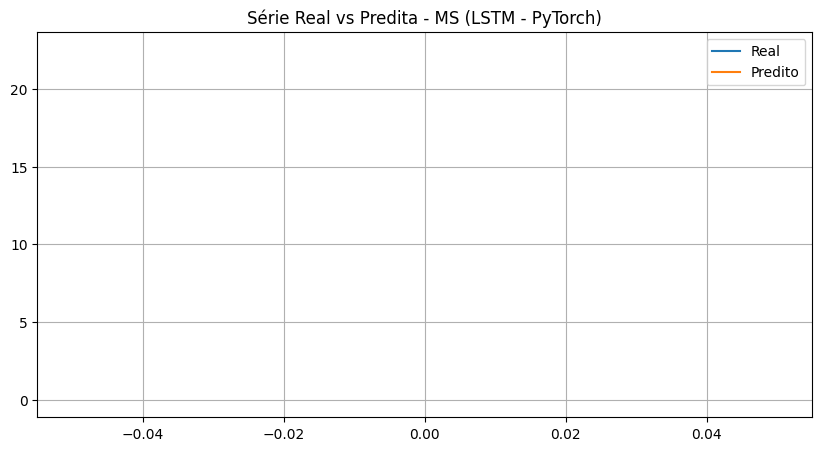

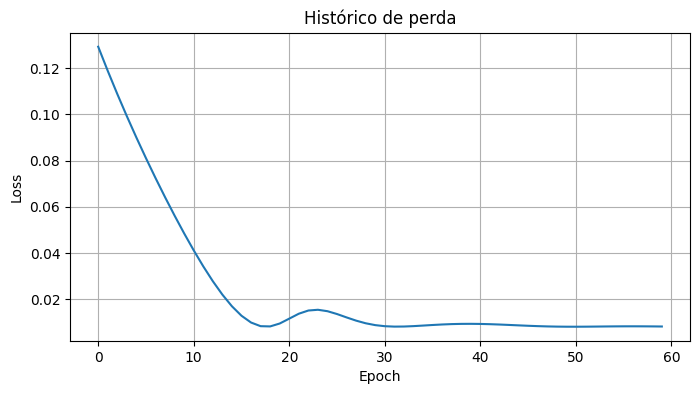

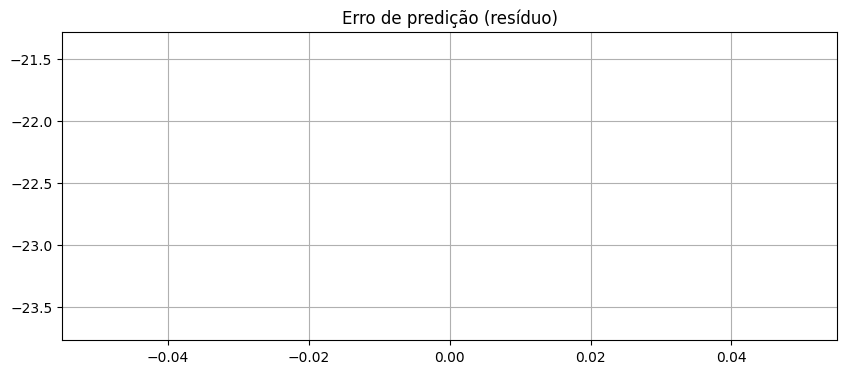

In [20]:
def train_predict_lstm(df, estado="MS", seq_len=1, epochs=60, batch_size=8):
    # 1. Seleciona a série do estado específico
    series = df.loc[estado].values.astype(float)
    print(f"Dados brutos para estado {estado}:", series)

    # Confere se a série não é constante ou vazia
    if np.all(series == 0):
        print("Atenção: série contém todos zeros, possível causa do problema no treino.")
    if len(series) <= seq_len:
        print("Atenção: série muito curta para criar sequências.")
        return None, None, None

    # 2. Normalização
    scaler = MinMaxScaler()
    series_scaled = scaler.fit_transform(series.reshape(-1, 1)).ravel()
    print("scaled::::", series_scaled)
    print("Dados normalizados (primeiros 10):", series_scaled[:10])

    # 3. Criação das sequências
    X, y = create_sequences(series_scaled, seq_len)
    print("Shape de X:", X.shape)
    print("Shape de y:", y.shape)

    # 4. Divisão treino/teste
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    print(f"Tamanho treino: {len(X_train)}, tamanho teste: {len(X_test)}")

    # 5. Conversão para tensores
    X_train_t = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
    X_test_t = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
    y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)
    print("Shape tensor X_train_t:", X_train_t.shape)
    print("Shape tensor y_train_t:", y_train_t.shape)

    # 6. DataLoader (somente treino)
    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)

    # 7. Modelo e dispositivo
    model = LSTMModel()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # 8. Treinamento
    loss_history = []
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        loss_avg = epoch_loss / len(train_loader)
        loss_history.append(loss_avg)
        print(f"Epoch {epoch + 1}/{epochs} - Loss: {loss_avg:.6f}")

    # 9. Avaliação do modelo
    model.eval()
    with torch.no_grad():
        y_pred_t = model(X_test_t.to(device)).cpu().numpy()
        y_test_np = y_test_t.cpu().numpy()

    # 10. Reshape para garantir formato correto para inversão
    y_pred_t = y_pred_t.reshape(-1, 1)
    y_test_np = y_test_np.reshape(-1, 1)

    # 11. Inverter normalização
    y_pred = scaler.inverse_transform(y_pred_t)
    y_test = scaler.inverse_transform(y_test_np)

    # 12. Verificação dos dados gerados para plotagem
    print("y_test (inverse transform):", y_test.flatten())
    print("y_pred (inverse transform):", y_pred.flatten())

    # 13. Métricas
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{estado} → RMSE: {rmse:.4f}, MAE: {mae:.4f}")

    # 14. Gráficos
    plt.figure(figsize=(10, 5))
    plt.plot(y_test, label='Real')
    plt.plot(y_pred, label='Predito')
    plt.title(f"Série Real vs Predita - {estado} (LSTM - PyTorch)")
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(loss_history)
    plt.title("Histórico de perda")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot((y_test - y_pred), label="Resíduo")
    plt.title("Erro de predição (resíduo)")
    plt.grid()
    plt.show()

    return model, y_test, y_pred


# Exemplo: Preparar o DataFrame pivotado antes de chamar
pivot_aux = df.pivot_table(values='taxa_permanencia', index='estado', columns='ano', fill_value=0)

print("pivot:", pivot_aux)
model, real, pred = train_predict_lstm(pivot_aux, estado='MS', seq_len=3, epochs=60)

In [47]:
df["alta_conclusao"] = (df["taxa_conclusao_acumulada"] > 0.7).astype(int)

# Separar os dois grupos com base no rendimento médio
# Grupo com benefício
df_com_beneficio = pd.DataFrame({
    'estado': df['estado'],
    'ano': df['ano'],
    'universidade': df['universidade'],
    'curso': df['curso'],
    'rendimento': df['rendimento_com_auxilio'],
    'taxa_permanencia': df['permanencia_com_auxilio'],
    'taxa_conclusao_acumulada': df['taxa_conclusao_acumulada'],
    'taxa_conclusao_anual': df['taxa_conclusao_anual'],
    'taxa_desistencia_anual': df['taxa_desistencia_anual'],
    'alta_conclusao': df['alta_conclusao'],
})

# Grupo sem benefício
df_sem_beneficio = pd.DataFrame({
    'estado': df['estado'],
    'ano': df['ano'],
    'universidade': df['universidade'],
    'curso': df['curso'],
    'rendimento': df['rendimento_sem_auxilio'],
    'taxa_permanencia': df['permanencia_sem_auxilio'],
    'taxa_conclusao_acumulada': df['taxa_conclusao_acumulada'],
    'taxa_conclusao_anual': df['taxa_conclusao_anual'],
    'taxa_desistencia_anual': df['taxa_desistencia_anual'],
    'alta_conclusao': df['alta_conclusao'],
})

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim

def treina_avalia(df_grupo, nome_grupo):
    features = [
        "taxa_permanencia",
        "taxa_conclusao_acumulada",
        "taxa_conclusao_anual",
        "taxa_desistencia_anual",
    ]
    X = df_grupo[features].fillna(0).values
    y = df_grupo["alta_conclusao"].values

    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    class MLPClassifier(nn.Module):
        def __init__(self, input_dim):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(input_dim, 32),
                nn.ReLU(),
                nn.Linear(32, 16),
                nn.ReLU(),
                nn.Linear(16, 1),
                nn.Sigmoid()
            )
        def forward(self, x):
            return self.net(x)

    input_dim = X_train.shape[1]
    model = MLPClassifier(input_dim)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    loss_history = []
    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        if epoch % 10 == 0:
            print(f"{nome_grupo} - Epoch {epoch} Loss: {loss.item():.4f}")

    # Avaliação
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        preds = model(X_test_tensor).numpy().flatten()
        preds_bin = (preds > 0.5).astype(int).flatten()

    acc = accuracy_score(y_test, preds_bin)
    fpr, tpr, _ = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    
    # --- Gráficos para o estado analisado ---
    plt.figure(figsize=(8, 4))
    plt.plot(loss_history, label='Loss')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.title(f'Curva de perda - {nome_grupo}')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.hist(preds[y_test == 0], bins=20, alpha=0.5, label='Não conclui')
    plt.hist(preds[y_test == 1], bins=20, alpha=0.5, label='Conclui')
    plt.xlabel('Probabilidade prevista')
    plt.ylabel('Amostras')
    plt.title(f'Histograma - {nome_grupo}')
    plt.legend()
    plt.grid(True)
    plt.show()

    cm = confusion_matrix(y_test, preds_bin)
    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Matriz de Confusão - {nome_grupo}')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Não conclui', 'Conclui'])
    plt.yticks(tick_marks, ['Não conclui', 'Conclui'])
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Curva ROC - {nome_grupo}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    return model, roc_auc, acc

resultados_estado = {}
estados_unicos = df['estado'].unique()

for estado in estados_unicos:
    df_estado = df[df['estado'] == estado].copy()
    if not df_estado.empty:
        modelo_com, auc_com, acc_com = treina_avalia(df_com_beneficio, estado + " Grupo Com Benefício")
        modelo_sem, auc_sem, acc_sem = treina_avalia(df_sem_beneficio, estado + " Grupo Sem Benefício")

df_resultados = pd.DataFrame(resultados_estado).T.sort_values('AUC', ascending=False)
plt.figure(figsize=(12,6))
df_resultados['AUC'].plot(kind='bar', color='skyblue')
plt.title("Performance do modelo (AUC) por Estado")
plt.xlabel("Estado")
plt.ylabel("AUC")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


AC Grupo Com Benefício - Epoch 0 Loss: 0.7023
